<a href="https://colab.research.google.com/github/billcai/computer-vision-tutorials/blob/main/food_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

### Useful readings
1. MIT 6.819/6.869: Advances in Computer Vision	(http://6.869.csail.mit.edu/sp21/schedule.html)
2. Stanford CS231n Convolutional Neural Networks for Visual Recognition (https://cs231n.github.io/), particularly chapters on Optimization and Backpropagation


Training a food model classifier
==============================================

**Adapted from**: `Sasank Chilamkurthy <https://chsasank.github.io>`

Objective of this tutorial
-  **Loading and preparing the dataset**: Preparing the dataset using TorchVision modules
-  **Finetuning model**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!pip install wget
import wget
# downloading dataset with wget
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
wget.download(url, 'dataset.tar.gz')

ERROR: Operation cancelled by user


KeyboardInterrupt: ignored

In [ ]:
# unzipping dataset
import tarfile
fname = 'dataset.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
different categories of food. The dataset is taken from [a public Kaggle dataset](https://www.kaggle.com/kmader/food41).

Download the data from [Kaggle](https://www.kaggle.com/kmader/food41) and upload it to Google Colab.

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

dataset = ImageFolder('food-101/images')
class_names = dataset.classes
print('Length of dataset is {}'.format(len(dataset)))

Length of dataset is 101000


In [ ]:
train_ratio = 0.7
test_ratio = 0.15
# val_ratio is therefore 0.15
train_len = int(round(len(dataset)*train_ratio))
test_len = int(round(len(dataset)*test_ratio))
val_len = len(dataset) - train_len - test_len
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_len, test_len, val_len])

In [ ]:
import os
import shutil
# may be unnecessary, but no clean way of doing ImageFolder with subsets and 
# different transformations
locations_dict = {
    'train':train_dataset,
    'val':val_dataset,
    'test':test_dataset}
for split in locations_dict:
  os.makedirs(split,exist_ok=True)
  for img in locations_dict[split].dataset.imgs:
    new_path = os.path.join(split,'/'.join(img[0].split('/')[-2:]))
    os.makedirs(os.path.dirname(new_path),exist_ok=True)
    shutil.copyfile(img[0],new_path)

In [ ]:
# clearing folders and files to reduce disk space usage
shutil.rmtree('sample_data')
shutil.rmtree('food-101')
os.remove('dataset.tar.gz')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomApply(
          [transforms.RandomRotation(30)]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = ImageFolder('train',transform=data_transforms['train'])
val_dataset = ImageFolder('val',transform=data_transforms['val'])
test_dataset = ImageFolder('test',transform=data_transforms['val'])
image_datasets = {
    'train':  train_dataset,
    'val':    val_dataset,
    'test':   test_dataset
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=512,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
class_names = dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

FileNotFoundError: ignored

In [ ]:
# check if using GPU
print('We will be using device {}'.format(device.type))

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing the model predictions**

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loading Pretrained Model and Training Model




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train and evaluate**




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 4.3568 Acc: 0.0822
val Loss: 3.7456 Acc: 0.2303

Epoch 1/24
----------
train Loss: 3.4677 Acc: 0.2713
val Loss: 2.8440 Acc: 0.3982

Epoch 2/24
----------
train Loss: 2.8836 Acc: 0.3732
val Loss: 2.3682 Acc: 0.4791

Epoch 3/24
----------
train Loss: 2.5476 Acc: 0.4280
val Loss: 2.0715 Acc: 0.5268

Epoch 4/24
----------
train Loss: 2.3311 Acc: 0.4642
val Loss: 1.8773 Acc: 0.5611

Epoch 5/24
----------
train Loss: 2.1764 Acc: 0.4891
val Loss: 1.7385 Acc: 0.5855

Epoch 6/24
----------
train Loss: 2.0569 Acc: 0.5122
val Loss: 1.6274 Acc: 0.6061

Epoch 7/24
----------
train Loss: 1.9934 Acc: 0.5249


In [ ]:
torch.save(model_ft.state_dict(), 'food_model.pt')

# Loading Pretrained Model and Running Inference

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
# upload model file here
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 101)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft.load_state_dict(torch.load('food_model.pt'))

<All keys matched successfully>

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomApply(
          [transforms.RandomRotation(30)]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def visualize_model(model, dataloader_val, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_val):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
test_dir_path = 'test-data'
test_dataset = ImageFolder(test_dir_path,data_transforms['val'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6,
                                             shuffle=True, num_workers=1)

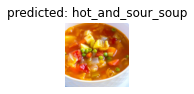

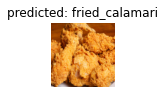

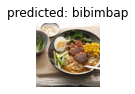

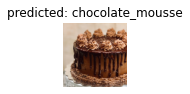

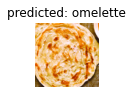

In [ ]:
visualize_model(model_ft,test_dataloader)